# Import libs and load files

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gdown
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
# download train and test set
gdown.download('https://drive.google.com/uc?export=download&id=1QdhIxh1QUEuLgRb7DWa7RA7CA08ybNRJ', 'train.zip', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1bGHeWeWYXj5biL9s-qTc9gyv91WNAbWE', 'test_kaggle.zip', quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1QdhIxh1QUEuLgRb7DWa7RA7CA08ybNRJ
To: /content/train.zip
2.27GB [00:30, 75.4MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1bGHeWeWYXj5biL9s-qTc9gyv91WNAbWE
To: /content/test_kaggle.zip
222MB [00:03, 55.7MB/s]


'test_kaggle.zip'

In [ ]:
# unzip train data
!unzip -q train.zip -d /content/train/

In [ ]:
# unzip test data
!unzip -q test_kaggle.zip -d /content/test/

In [ ]:
# forming train and test paths
train_dir = Path('/content/train/')
test_dir = Path('/content/test/')

In [ ]:
# load training dataframe
df = pd.read_csv('train.csv')

df.head()

,Unnamed: 0,image_path,emotion
0,0,./train/anger/0.jpg,anger
1,1,./train/anger/1.jpg,anger
2,2,./train/anger/10.jpg,anger
3,3,./train/anger/100.jpg,anger
4,4,./train/anger/1000.jpg,anger


# Dataframe statistics

Looking for missing values

In [ ]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50046 entries, 0 to 50045
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  50046 non-null  int64 
 1   image_path  50046 non-null  object
 2   emotion     50046 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


No missing. That's good.

Class distribution

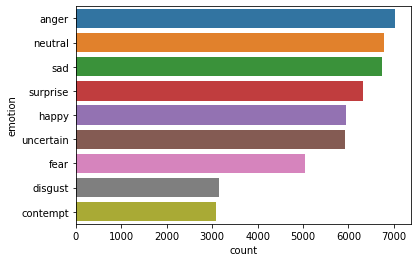

In [ ]:
sns.countplot(
    y='emotion',
    order=df['emotion'].value_counts().index,
    data=df
)

That seems not good but let's find out how high will be overall accuracy

# Choosing model

Accordint to this article https://towardsdatascience.com/top-10-cnn-architectures-every-machine-learning-engineer-should-know-68e2b0e07201 I would like to test 3 diffenent models:


*   DenseNet121
*   VGG-16
*   ResNet50V2



In [ ]:
dense_model = tf.keras.applications.DenseNet121(include_top=False)

In [ ]:
vgg_model = tf.keras.applications.VGG16(include_top=False)

In [ ]:
resnet_model = tf.keras.applications.ResNet50V2(include_top=False)

# DenseNet121

**model #1**


1.   Freeze model
2.   Train using original dataset

In [ ]:
# define hyperparametrs
IMG_SHAPE=224
NUM_CLASSES = 9

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_dense

In [ ]:
def make_train_gen(preprocess_func, directory=train_dir, img_shape=IMG_SHAPE):
  """

  function to make train generator
  input:  preprocess_func - preprocess function of model
          directory - path to train data
          img_shape - image shape for model input
  output: train_gen - complete generator for training

  """

  train_gen = ImageDataGenerator(
      preprocessing_function=preprocess_func).flow_from_dataframe(
          # select dataframe
          dataframe=df,
          directory=directory,
          # select column with images
          x_col='image_path',
          # select column with classes
          y_col='emotion',
          target_size=(img_shape, img_shape)
      )
  
  return train_gen

In [ ]:
def build_model(model, trainable=False, show_model=True):
  """

  build model for training
  input:  model - original model
          trainable - False=freeze model
                      True=do not freeze model
          show_model -  True=show plot
                        False=hide plot
  output: new_model - model for training

  """

  # here we decide to freeze model or not
  model.trainable = trainable
  # look at model plot
  if show_model:
    model.summary()

  # define output model
  new_model = tf.keras.Sequential([
    model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
  
  return new_model

In [ ]:
def training(model, train_data, optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.categorical_crossentropy, epochs=20):
  """

  train certain model
  input:  model - trained model
          optimizer - optimizer
          train_data - data for training
          loss - loss
          epochs - number of epochs

  """

  # select optimizer, loss and metric
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=tf.keras.metrics.CategoricalAccuracy()
                )
  
  # fit training generator
  model.fit_generator(
      generator=train_data,
      epochs=epochs,
      callbacks=[PlotLossesCallback()]
      )

In [ ]:
train_gen_dense = make_train_gen(preprocess_input_dense)

Found 50046 validated image filenames belonging to 9 classes.


In [ ]:
dense1_model = build_model(dense_model)

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
________________________________________________________________________________________

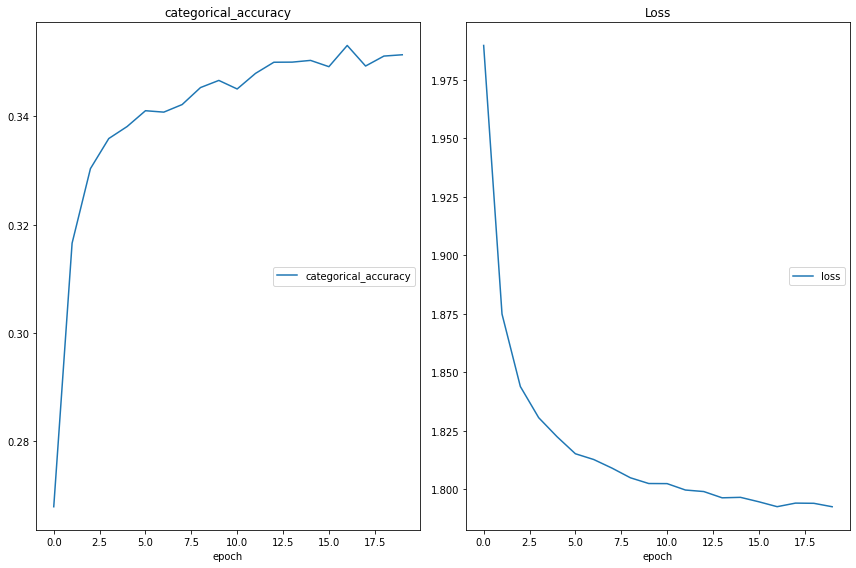

categorical_accuracy
	categorical_accuracy 	 (min:    0.268, max:    0.353, cur:    0.351)
Loss
	loss             	 (min:    1.793, max:    1.990, cur:    1.793)


In [ ]:
# training first model
training(dense1_model, train_gen_dense)

In [ ]:
def make_test_gen(preprocess_func, directory=test_dir, img_shape=IMG_SHAPE):
  """

  function to make test generator
  input:  preprocess_func - preprocess function of model
          directory - path to test data
          img_shape - image shape for model input
  output: test_gen - complete generator for making predictions

  """

  test_gen = ImageDataGenerator(
      preprocessing_function=preprocess_func).flow_from_directory(
          directory=directory,
          target_size=(IMG_SHAPE, IMG_SHAPE),
          # turn off to not mix our submission file
          shuffle=False
          )

  return test_gen

In [ ]:
def make_predictions(model, test_data):
  """

  predictions for submission file
  input:  model - model which was used for training
          test_data - test generator
  output: predictions - images with predicted emotions
  
  """

  return model.predict_classes(test_data)

In [ ]:
def make_submission(filename, predictions, train_gen, test_gen):
  """

  function to make submission file for kaggle competition

  input:  filename - name of submission file, i.e. xxx.csv
          predictions - model predictions
          test_gen - test generator
          
  """

  # define image_path column
  image_path = [path.split('/')[1] for path in test_gen.filenames]
  # take list of classes
  classes = list(train_gen.class_indices)
  print(classes)
  # define emotion column
  emotion = [classes[i] for i in predictions]
  # create dataframe
  submission = pd.DataFrame({'image_path': image_path, 'emotion': emotion})
  # save file
  submission.to_csv(filename, index=False)

In [ ]:
test_gen_dense = make_test_gen(preprocess_input_dense)

Found 5000 images belonging to 1 classes.


In [ ]:
predictions_dense1 = make_predictions(dense1_model, test_gen_dense)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
make_submission(
    'model_1.csv', predictions_dense1, train_gen_dense, test_gen_dense)



*   **Train acc:** *35%*
*   **Test acc:** *31%*



**model #2**


1.   Do not freeze model
2.   Train using original dataset



In [ ]:
dense2_model = build_model(dense_model, True, False)

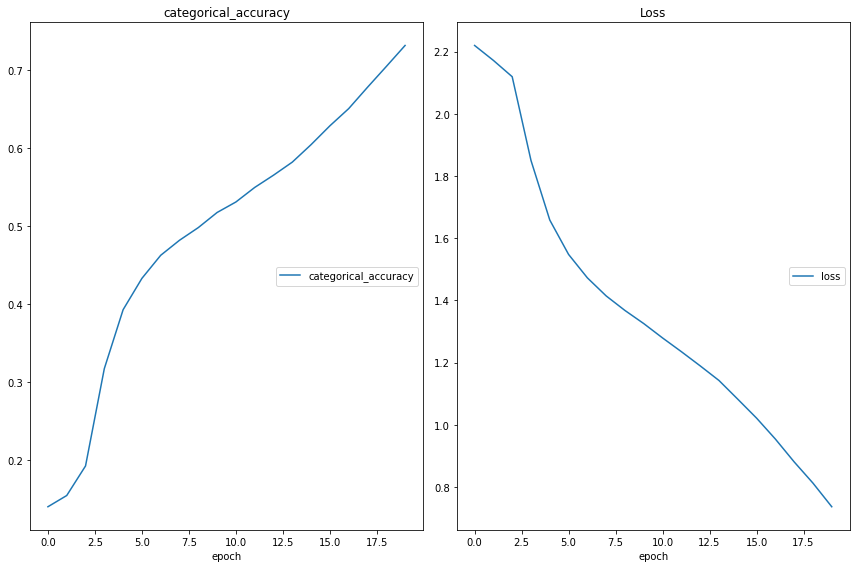

categorical_accuracy
	categorical_accuracy 	 (min:    0.141, max:    0.732, cur:    0.732)
Loss
	loss             	 (min:    0.737, max:    2.220, cur:    0.737)


In [ ]:
training(dense2_model, train_gen_dense)

In [ ]:
predictions_dense2 = make_predictions(dense2_model, test_gen_dense)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
make_submission(
    'model_2.csv', predictions_dense2, train_gen_dense, test_gen_dense)



*   **Train acc:** *73%*
*   **Test acc:** *47%*



# VGG16

**model #3**


1.   Freeze model
2.   Train using original dataset



In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg

In [ ]:
train_gen_vgg = make_train_gen(preprocess_input_vgg)

Found 50046 validated image filenames belonging to 9 classes.


In [ ]:
vgg1_model = build_model(vgg_model)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

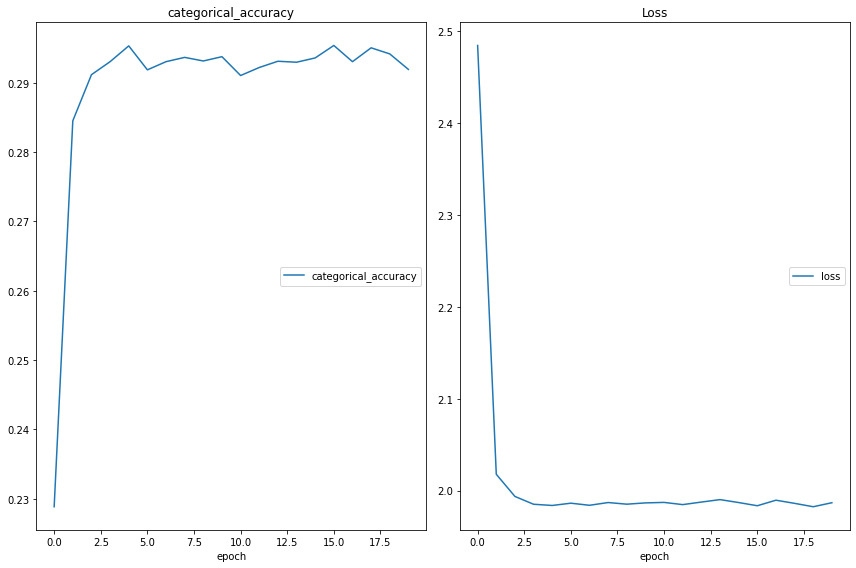

categorical_accuracy
	categorical_accuracy 	 (min:    0.229, max:    0.295, cur:    0.292)
Loss
	loss             	 (min:    1.983, max:    2.484, cur:    1.987)


In [ ]:
training(vgg1_model, train_gen_vgg)

In [ ]:
test_gen_vgg = make_test_gen(preprocess_input_vgg)

Found 5000 images belonging to 1 classes.


In [ ]:
predictions_vgg1 = make_predictions(vgg1_model, test_gen_vgg)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
make_submission(
    'model_3.csv', predictions_vgg1, train_gen_vgg, test_gen_vgg)



*   **Train acc:** *30%*
*   **Test acc:** *27%*



**model #4**


1.   Do not freeze model
2.   Train using original dataset



In [ ]:
vgg2_model = build_model(vgg_model, True, False)

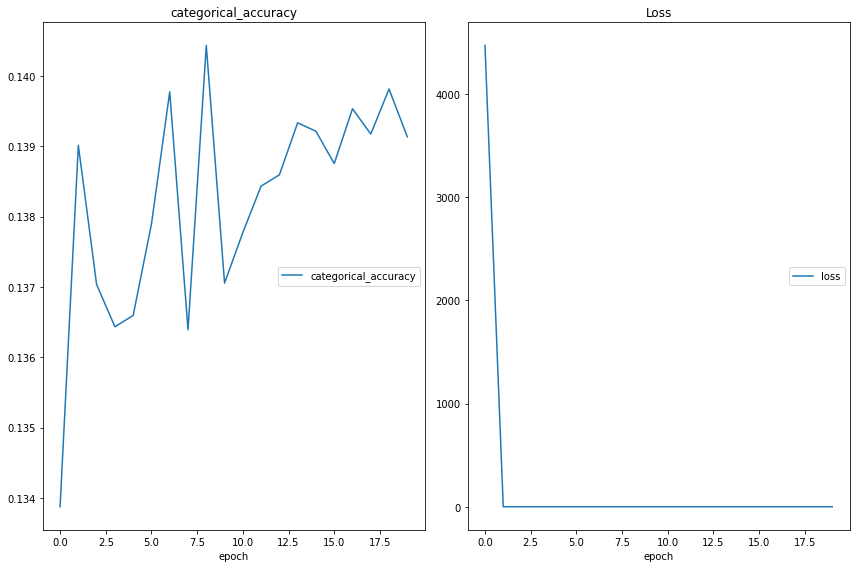

categorical_accuracy
	categorical_accuracy 	 (min:    0.134, max:    0.140, cur:    0.139)
Loss
	loss             	 (min:    2.162, max: 4468.725, cur:    2.162)


In [ ]:
training(vgg2_model, train_gen_vgg)

In [ ]:
predictions_vgg2 = make_predictions(vgg2_model, test_gen_vgg)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
make_submission(
    'model_4.csv', predictions_vgg2, train_gen_vgg, test_gen_vgg)



*   **Train acc:** *14%*
*   **Test acc:** *14%*



# ResNet50V2

**model #5**


1.   Do not freeze model
2.   Train using original dataset



In [ ]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_input_resnet

In [ ]:
train_gen_resnet = make_train_gen(preprocess_input_resnet)

Found 50046 validated image filenames belonging to 9 classes.


In [ ]:
resnet1_model = build_model(resnet_model, True)

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

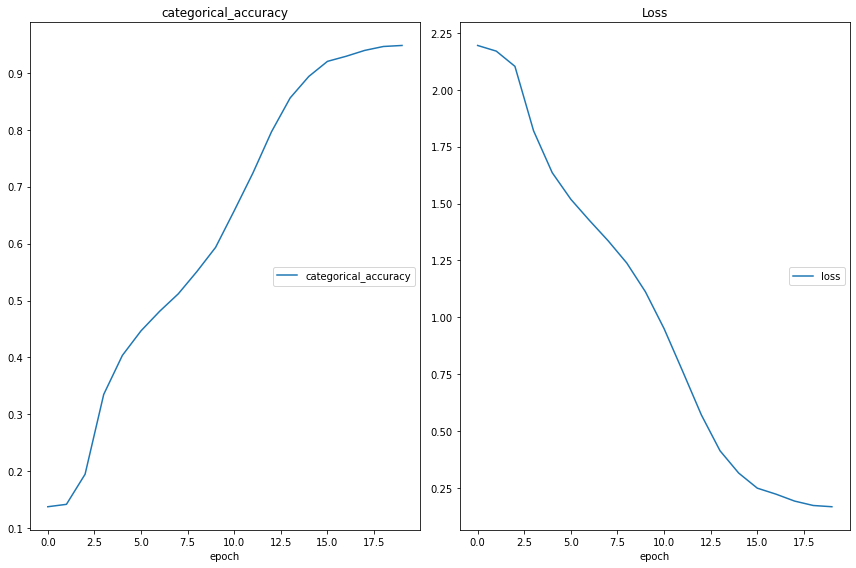

categorical_accuracy
	categorical_accuracy 	 (min:    0.138, max:    0.948, cur:    0.948)
Loss
	loss             	 (min:    0.168, max:    2.195, cur:    0.168)


In [ ]:
training(resnet1_model, train_gen_resnet)

In [ ]:
test_gen_resnet = make_test_gen(preprocess_input_resnet)

Found 5000 images belonging to 1 classes.


In [ ]:
predictions_resnet1 = make_predictions(resnet1_model, test_gen_resnet)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
make_submission(
    'model_5.csv', predictions_resnet1, train_gen_resnet, test_gen_resnet)



*   **Train acc:** *95%*
*   **Test acc:** *44%*



**model #6**


1.   Do not freeze model
2.   Train using augmented dataset



In [ ]:
def make_aug_train_gen(
    preprocess_func, directory=train_dir, img_shape=IMG_SHAPE):
  """

  augment dataset for training
  input:  preprocess_func - preprocess function of model
          directory - path to train data
          img_shape - image shape for model input
  output: aug_train_gen - complete generator for training

  """

  aug_gen = ImageDataGenerator(
      # max rotation range
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      zoom_range=0.2,
      # random horizontal reflection
      horizontal_flip=True,
      # random vertical reflection
      vertical_flip=True,
      # rescale=1./255,
      preprocessing_function=preprocess_func
  )

  aug_train_gen = aug_gen.flow_from_dataframe(
      # select dataframe
      dataframe=df,
      directory=directory,
      # select column with images
      x_col='image_path',
      # select column with classes
      y_col='emotion',
      target_size=(img_shape, img_shape)
  )

  return aug_train_gen

In [ ]:
aug_train_gen = make_aug_train_gen(preprocess_input_resnet)

Found 50046 validated image filenames belonging to 9 classes.


In [ ]:
resnet2_model = build_model(resnet_model, True, False)

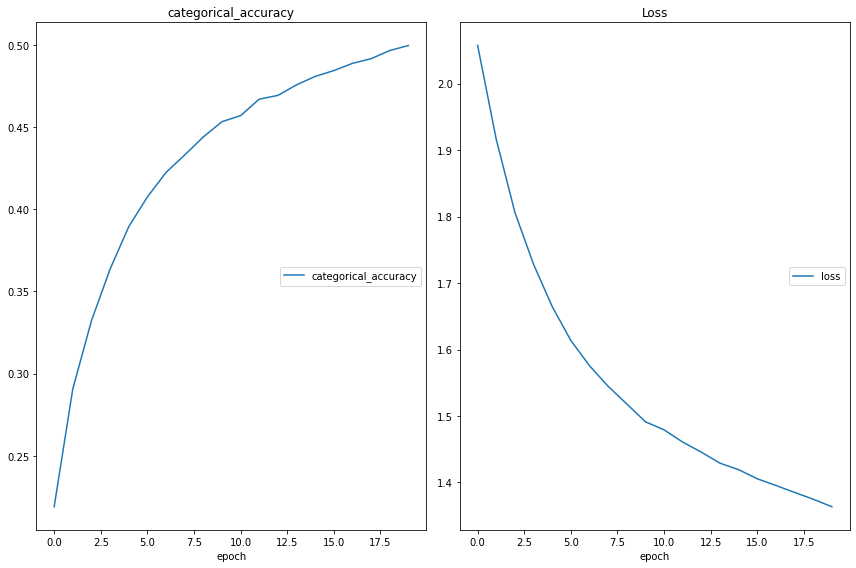

categorical_accuracy
	categorical_accuracy 	 (min:    0.219, max:    0.500, cur:    0.500)
Loss
	loss             	 (min:    1.363, max:    2.057, cur:    1.363)


In [ ]:
training(resnet2_model, aug_train_gen)

In [ ]:
predictions_resnet2 = make_predictions(resnet2_model, test_gen_resnet)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
make_submission(
    'model_6.csv', predictions_resnet2, aug_train_gen, test_gen_resnet)



*   **Train acc:** *50%*
*   **Test acc:** *50%*



In [ ]:
# resnet2_model.save_weights('model_6')